# Research Notebook 

## The goal

The goal here is to understand the impact that data gaps have on the L01 pipeline. As seen, the impact of gaps on the telemetry variables result in a widening of the data gaps in the overall Michelson-like variables. I want to try and understand 

* What type of data gap is most impacted
* What generation of TDI is most impactful
* What do the data gap widening depend on? 
* Can I build a distribution of data gaps?

In [447]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
data_direc = "../data_for_simulations"
sys.path.append("../../artifacts_gen/gaps/")  # if gap_widening_utils.py is in the parent directory
from lisa_gap import GapMaskGenerator

sys.path.append("../utility_funcs")  # if gap_widening_utils.py is in the parent directory
from gap_widening_utils import (
    construct_mask_single_gap,
    gap_augmentation_expression,
    widening_gap_X1,
    widening_gap_X2
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set up the instrument simulator

In [448]:
from lisaconstants import au, SPEED_OF_LIGHT
from lisaorbits import StaticConstellation

### average light travel time ##
armlength = 2.5E9  # considering the standard value for the entire mission duration 

barycenter = [au, 0, 0] # m
orbits = StaticConstellation.from_armlengths(
    armlength, armlength, armlength, barycenter)

orbits.write("static_orbits.h5", mode = 'w')

2025-08-15 14:16:21,943 - INFO - Initializing orbits (lisaorbit verion 2.4.2)
2025-08-15 14:16:21,946 - INFO - Creating orbit file static_orbits.h5
2025-08-15 14:16:22,004 - INFO - Closing orbit file static_orbits.h5


In [ ]:
#### --------  Note that you can also set up in this way ---------- ### 

#    MOSAS = ['12', '23', '31', '13', '32', '21']
#    armlength = 2.54E9/SPEED_OF_LIGHT
#    orbits = {mosa: armlength for mosa in MOSAS}
#    instr = Instrument(size=simlen, dt = 0.25, lock='six', seed=1234, orbits=orbits)
#    instr.disable_all_noises() 
#    instr.simulate()

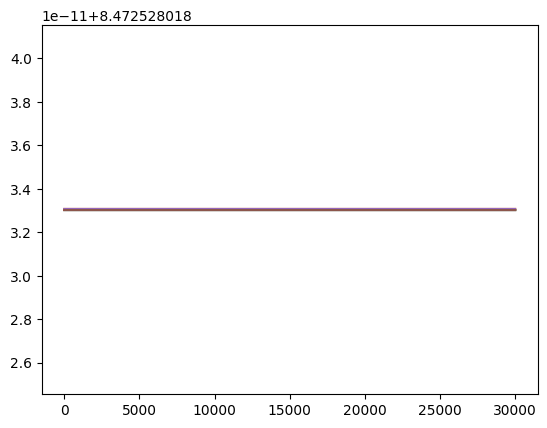

In [42]:
t = np.arange(0, 120_000*0.25,0.25)
for j in range(6):
    plt.plot(t, orbits.compute_ltt(t)[:,j], label=f"arm {j+1}")

In [449]:
# Set up lolipops pipeline
from pathlib import Path
from lisainstrument import Instrument
import logging

simlen = 20_000

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.getLogger('lisainstrument').setLevel(logging.INFO)
instr_static = Instrument(size=simlen, dt = 0.25, orbits = 'static_orbits.h5', seed=1234)

instr_static.disable_all_noises(excluding=['laser', 'test-mass', 'oms']) 
instr_static.simulate()

instr_static.write('static_short_simulation.h5', mode='w')

2025-08-15 14:16:46,065 - INFO - Initializing instrumental simulation
2025-08-15 14:16:46,073 - INFO - Computing measurement time vector (size=20000, dt=0.25)
2025-08-15 14:16:46,075 - INFO - Computing physics time vector (size=80000, dt=0.0625)
2025-08-15 14:16:46,079 - INFO - Computing telemetry time vector (size=2, dt=86400.0)
2025-08-15 14:16:46,092 - INFO - Using orbit file 'static_orbits.h5'
2025-08-15 14:16:46,711 - INFO - Using pre-defined locking configuration 'N1-12'
2025-08-15 14:16:46,712 - WARNING - Using default set of locking beatnote frequencies; this might cause interferometric beatnote frequencies to fall outside the requirement range of 5..25 MHz
2025-08-15 14:16:46,713 - INFO - Designing antialiasing filter ('kaiser', 240, 1.1, 2.9)
2025-08-15 14:16:46,720 - INFO - Starting simulation
2025-08-15 14:16:46,721 - INFO - Generating clock noise
2025-08-15 14:16:46,791 - INFO - Generating modulation noise
2025-08-15 14:16:46,791 - INFO - Generating backlink noise
2025-08-

In [450]:
from pytdi import Data

from pytdi.michelson import compute_factorized_michelson

data = Data.from_instrument(instr_static)

2025-08-15 14:16:49,274 - INFO - Loading instrument object '<lisainstrument.instrument.Instrument object at 0x1231f6300>'
2025-08-15 14:16:49,276 - WARNING - You are using LISA Instrument in a version that might not be fully supported
2025-08-15 14:16:49,277 - INFO - Initializing data object
2025-08-15 14:16:49,277 - INFO - Computing delay derivatives


# Widening of the gap due to delays
## The $\eta$ variables

Now in the next cell we are going to verify our formula for the widening of the eta variables

In [451]:
measurement_values = data.MEASUREMENTS
ifos = data.measurements

mprs = data.delays
mpr_derivatives = data.delay_derivatives
MOSAS = data.MOSAS
dt = 1/data.fs

In [401]:
# I want to trim the mprs values by 1000 points at the start and end
N = 1000
mprs_trimmed = {}
for item in list(mprs.keys()):
    mprs_trimmed[item] = mprs[item][1000:-1000]

In [452]:
def nanify_telemetry_variables(data, masking_function):
    """
    Apply a masking function (with NaNs) to telemetry variables, pseudo-ranges, and their derivatives.

    Args:
        data (object): Telemetry object with .ifos attribute (dict-like).
        masking_function (np.ndarray): Array of 1s and NaNs to apply as a mask.

    Returns:
        tuple: (telemetry_w_gaps, mprs_w_nans, mpr_derivatives_w_nans)
            telemetry_w_gaps: telemetry object with masked .ifos fields
            mprs_w_nans: dict of masked pseudo-ranges
            mpr_derivatives_w_nans: dict of masked pseudo-range derivatives
        telemetry (object): Telemetry object with .ifos attribute (dict-like).
        mprs (dict): Dictionary of pseudo-range arrays, keyed by MOSA.
        mpr_derivatives (dict): Dictionary of pseudo-range derivative arrays, keyed by MOSA.
        masking_function (np.ndarray): Array of 1s and NaNs to apply as a mask.

    Returns:
        tuple: (telemetry_w_gaps, mprs_w_nans, mpr_derivatives_w_nans)
            telemetry_w_gaps: telemetry object with masked .ifos fields
            mprs_w_nans: dict of masked pseudo-ranges
            mpr_derivatives_w_nans: dict of masked pseudo-range derivatives
    """
    import copy

    # Deep copy to avoid modifying original data
    MOSAS = data.MOSAS
    data_w_gaps = copy.deepcopy(data)

    # Build label lists for all relevant telemetry fields
    tmi_label = [f"tmi_{mosa}" for mosa in MOSAS]
    rfi_label = [f"rfi_{mosa}" for mosa in MOSAS]
    rfi_sb_label = [f"rfi_sb_{mosa}" for mosa in MOSAS]
    isi_label = [f"isi_{mosa}" for mosa in MOSAS]
    isi_sb_label = [f"isi_sb_{mosa}" for mosa in MOSAS]

    # Apply mask to all telemetry fields
    for tmi_item, rfi_item, rfi_sb_item, isi_item, isi_sb_item in zip(
        tmi_label, rfi_label, rfi_sb_label, isi_label, isi_sb_label
    ):
        data_w_gaps.measurements[tmi_item] = data.measurements[tmi_item] * masking_function
        data_w_gaps.measurements[rfi_item] = data.measurements[rfi_item] * masking_function
        data_w_gaps.measurements[rfi_sb_item] = data.measurements[rfi_sb_item] * masking_function
        data_w_gaps.measurements[isi_item] = data.measurements[isi_item] * masking_function
        data_w_gaps.measurements[isi_sb_item] = data.measurements[isi_sb_item] * masking_function

    # Deep copy and mask pseudo-ranges and their derivatives
    for delay_craft in list(data.delays.keys()):
        data_w_gaps.delays[delay_craft] = masking_function * data.delays[delay_craft]
        data_w_gaps.delay_derivatives[delay_craft] = masking_function * data.delay_derivatives[delay_craft]

    return data_w_gaps 

Lost out on approximately 0.0013888888888888887 hours of data
This ammounts to 20 number of samples


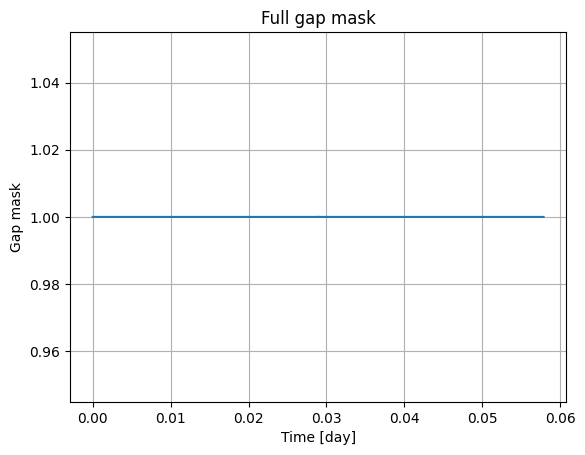

In [403]:
# Construct gap class

CONTROL_NANS = True
GAP_CLASS = False

sim_t = np.arange(0, simlen * dt, dt)


N_tel_nans= 20

masking_function = construct_mask_single_gap(N_tel_nans, length = simlen)


plt.plot(sim_t / 60 / 60 / 24, masking_function)
plt.title("Full gap mask")
plt.xlabel("Time [day]")
plt.ylabel("Gap mask")
plt.grid(True)

print(
    "Lost out on approximately",
    np.sum(np.isnan(masking_function)) * 0.25 / 60 / 60,
    "hours of data",
)
print(
    "This ammounts to {} number of samples".format(np.sum(np.isnan(masking_function)))
)

In [453]:
from pytdi.intervar import compute_etas

N_nans = 2000
order = 27
masking_function = construct_mask_single_gap(N_nans, length = simlen)
data_w_gaps = nanify_telemetry_variables(data, masking_function)
etas_w_gaps_nans = compute_etas(data_w_gaps, order, unit = "frequency")

N_nans_in_data = np.sum(np.isnan(data_w_gaps.measurements["tmi_12"]))
print("Number of nans in data", N_nans_in_data)
N_nans_in_eta_pytdi = np.sum(np.isnan(etas_w_gaps_nans["eta_12"]))
widening_gap_eta_pytdi = N_nans_in_eta_pytdi - N_nans
print("Number of nans in the eta variables = ", N_nans_in_eta_pytdi)
print("Overall widening of gap in eta variables = ", widening_gap_eta_pytdi)

2025-08-15 14:17:08,440 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x12255e6f0>'
2025-08-15 14:17:08,441 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x12255e6f0>'
2025-08-15 14:17:08,493 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x122579bb0>'
2025-08-15 14:17:08,494 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x122579bb0>'
2025-08-15 14:17:08,509 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x1223b44d0>'
2025-08-15 14:17:08,510 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x1223b44d0>'
2025-08-15 14:17:08,556 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x122579b80>'
2025-08-15 14:17:08,557 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x122579b80>'
2025-08-15 14:17:08,579 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x122579e20>'
2025-08-15

Number of nans in data 2000
Number of nans in the eta variables =  2047
Overall widening of gap in eta variables =  47


In [454]:
# Check formula with analytical computation:
# we can consider three type of delays:

# 1) constant delay equal to the average one which in this case is used to run the simulation

constant_delay1 = data_w_gaps.delays['d_12'][1000:][0]

# 2) constant delay equal to the maximum  value for the entire mission duration 

constant_delay2 = np.float64(2.54E9/SPEED_OF_LIGHT)

# 3)  constant delay equal to the minimum   value for the entire mission duration 

constant_delay3 = np.float64(2.45E9/SPEED_OF_LIGHT)




In [455]:
###  here we pick which value we want to use for the analytical computation

constant_delay = constant_delay1

In [456]:
########## -------------- ########


delay = constant_delay/dt # Here we take the mean LTT. 

widening_gap_eta_theory, N_nans_in_eta_theory = gap_augmentation_expression(order, N_nans, delay, delay_number=1.0)
print("Number of nans in the eta variables = ", N_nans_in_eta_theory)
print("Overall widening of gap in eta variables = ", widening_gap_eta_theory)

Number of nans in the eta variables =  2047
Overall widening of gap in eta variables =  47


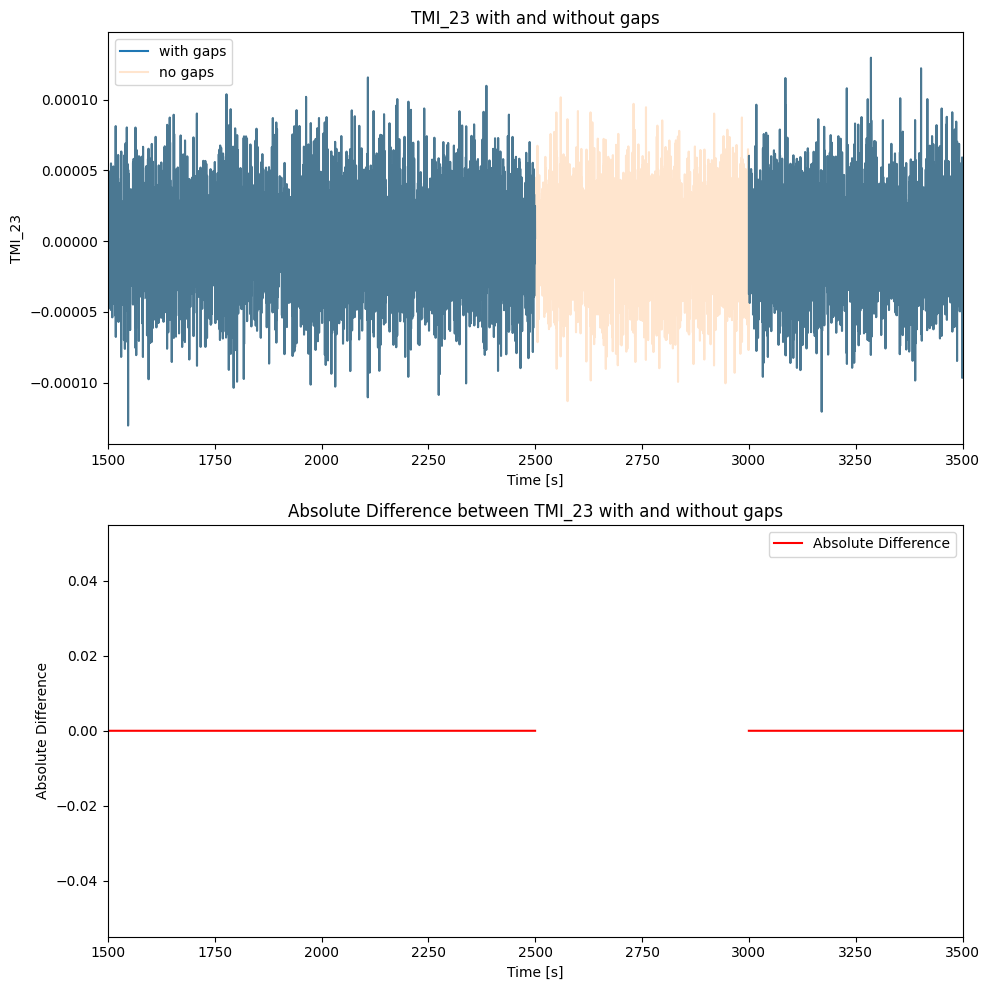

In [457]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

idx_start_gap = np.argwhere(np.isnan(masking_function) == True)[0][0]
idx_end_gap = np.argwhere(np.isnan(masking_function) == True)[-1][-1]
# First subplot: Original plot with gaps and no gaps
j = 1000
axs[0].plot(sim_t, data_w_gaps.measurements["tmi_23"], label="with gaps", alpha=1)
axs[0].plot(sim_t, data.measurements["tmi_23"], label="no gaps", alpha=0.2)
axs[0].set_xlim([sim_t[idx_start_gap] - j, sim_t[idx_start_gap] + j])
axs[0].set_ylabel(r"TMI_23")
# axs[0].set_ylim([-4100, -3200])
axs[0].set_xlabel("Time [s]")
axs[0].legend()
axs[0].set_title("TMI_23 with and without gaps")

# Second subplot: Absolute difference between the two
absolute_difference = np.abs(data_w_gaps.measurements["tmi_23"] - data.measurements["tmi_23"])
axs[1].plot(sim_t, absolute_difference, label="Absolute Difference", color="red")
axs[1].set_xlim([sim_t[idx_start_gap] - j, sim_t[idx_start_gap] + j])
axs[1].set_ylabel("Absolute Difference")
axs[1].set_xlabel("Time [s]")
axs[1].legend()
axs[1].set_title("Absolute Difference between TMI_23 with and without gaps")

plt.tight_layout()
plt.show()

In [458]:
order = 45
results_testing_N_nans = []
N_nans_in_telem_values = np.logspace(0, 2, num=50, dtype=int)  # Logarithmic spacing from 1 to 10000

for N_nans in tqdm(N_nans_in_telem_values):
    # Construct masking function
    masking_function = construct_mask_single_gap(N_nans, length=simlen)
        
    # Generate telemetry with gaps
    data_w_gaps = nanify_telemetry_variables(data, masking_function)

    # Compute eta variables with gaps
    etas_w_gaps_nans = compute_etas(data_w_gaps, order, unit="frequency")        
    # Calculate N_nans and widening for pytdi
    N_nans_in_eta_pytdi = np.sum(np.isnan(etas_w_gaps_nans["eta_12"]))
    widening_gap_eta_pytdi = N_nans_in_eta_pytdi - N_nans

    # Calculate N_nans and widening for theoretical model
    widening_gap_eta_theory, N_nans_in_eta_theory = gap_augmentation_expression(
        order, N_nans, delay, delay_number=1
    )
        
    # Append results to the list
    results_testing_N_nans.append({
        "N_nans": N_nans,
        "N_nans_in_eta_pytdi": N_nans_in_eta_pytdi,
        "N_nans_in_eta_theory": N_nans_in_eta_theory,
        "widening_gap_eta_pytdi": widening_gap_eta_pytdi,
        "widening_gap_eta_theory": widening_gap_eta_theory
    })
    

  0%|          | 0/50 [00:00<?, ?it/s]2025-08-15 14:17:42,839 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x12255e6f0>'
2025-08-15 14:17:42,840 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x12255e6f0>'
/Users/murmar/opt/anaconda3/envs/gaps_tdi_env/lib/python3.12/site-packages/pytdi/dsp.py:113: RuntimeWarning: invalid value encountered in cast
  shift_ints = shift_ints.astype(int)
2025-08-15 14:17:42,897 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x122579bb0>'
2025-08-15 14:17:42,898 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x122579bb0>'
2025-08-15 14:17:42,945 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x1223b44d0>'
2025-08-15 14:17:42,946 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x1223b44d0>'
2025-08-15 14:17:42,974 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x122579b80>'
2025-08-15 

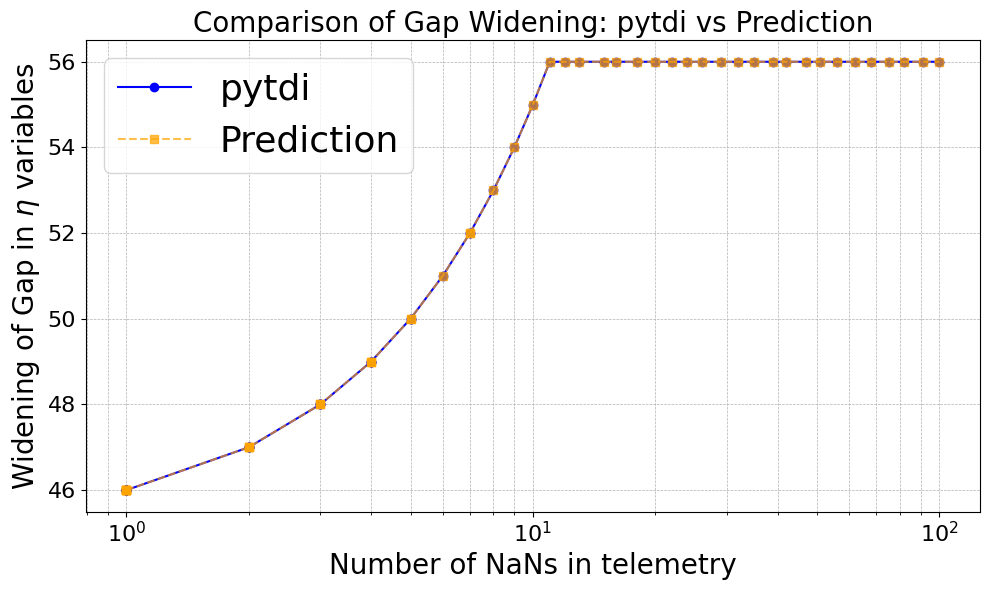

In [459]:
# Plot the results of the above cell

import matplotlib.pyplot as plt
import numpy as np

# Extract data from results
N_nans_in_telem_values = [result["N_nans"] for result in results_testing_N_nans]
widening_gap_eta_pytdi = [result["widening_gap_eta_pytdi"] for result in results_testing_N_nans]
widening_gap_eta_theory = [result["widening_gap_eta_theory"] for result in results_testing_N_nans]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(N_nans_in_telem_values, widening_gap_eta_pytdi, label="pytdi", marker="o", linestyle="-", color="blue")
plt.plot(N_nans_in_telem_values, widening_gap_eta_theory, label="Prediction", marker="s", linestyle="--", color="orange", alpha = 0.7)

# Add labels, legend, and grid
plt.xscale("log")
plt.xlabel("Number of NaNs in telemetry", fontsize=20)
plt.ylabel(r"Widening of Gap in $\eta$ variables", fontsize=20)
plt.title("Comparison of Gap Widening: pytdi vs Prediction", fontsize=20)
plt.legend(fontsize=26)

# Increase tick sizes
plt.tick_params(axis="both", which="major", labelsize=16)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Save and show the plot
plt.tight_layout()
# plt.savefig("../Plots/gap_widening_comparison.png", dpi=300)  # Save as a high-resolution image
plt.show()

# What do we learn here?
## For large strings of missing data, gap augmentation is constant. 



In [442]:
results_by_order = {}

# Define the gap configurations and range of orders
gap_configurations = [1, 10 , 100]
orders = range(25, 81,2)  # From 25 to 81 inclusive

# Loop over each gap configuration
for N_nans in gap_configurations:
    results_by_order[N_nans] = []  # Initialize results for this gap configuration
    
    # Construct masking function
    masking_function = construct_mask_single_gap(N_nans, length=simlen) 
    # Generate telemetry with gaps
    data_w_gaps = nanify_telemetry_variables(data, masking_function)
    for order in tqdm(orders):
        
        # Compute eta variables with gaps
        etas_w_gaps_nans = compute_etas(data_w_gaps, order, unit="frequency")        
        # Calculate N_nans and widening for pytdi
        N_nans_in_eta_pytdi = np.sum(np.isnan(etas_w_gaps_nans["eta_12"]))
        widening_gap_eta_pytdi = N_nans_in_eta_pytdi - N_nans

        # Calculate N_nans and widening for theoretical model
        widening_gap_eta_theory, N_nans_in_eta_theory = gap_augmentation_expression(
            order, N_nans, delay, delay_number=1
        )
        
        # Append results to the list for this gap configuration
        results_by_order[N_nans].append({
            "order": order,
            "N_nans_in_eta_pytdi": N_nans_in_eta_pytdi,
            "N_nans_in_eta_theory": N_nans_in_eta_theory,
            "widening_gap_eta_pytdi": widening_gap_eta_pytdi,
            "widening_gap_eta_theory": widening_gap_eta_theory
        })

  0%|          | 0/28 [00:00<?, ?it/s]2025-08-11 14:43:50,658 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x12255e6f0>'
2025-08-11 14:43:50,659 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x12255e6f0>'
2025-08-11 14:43:50,672 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x122579bb0>'
2025-08-11 14:43:50,673 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x122579bb0>'
2025-08-11 14:43:50,686 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x1223b44d0>'
2025-08-11 14:43:50,687 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x1223b44d0>'
2025-08-11 14:43:50,700 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x122579b80>'
2025-08-11 14:43:50,700 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x122579b80>'
2025-08-11 14:43:50,709 - INFO - Building combination '<pytdi.core.LISATDICombinat

<Figure size 640x480 with 0 Axes>

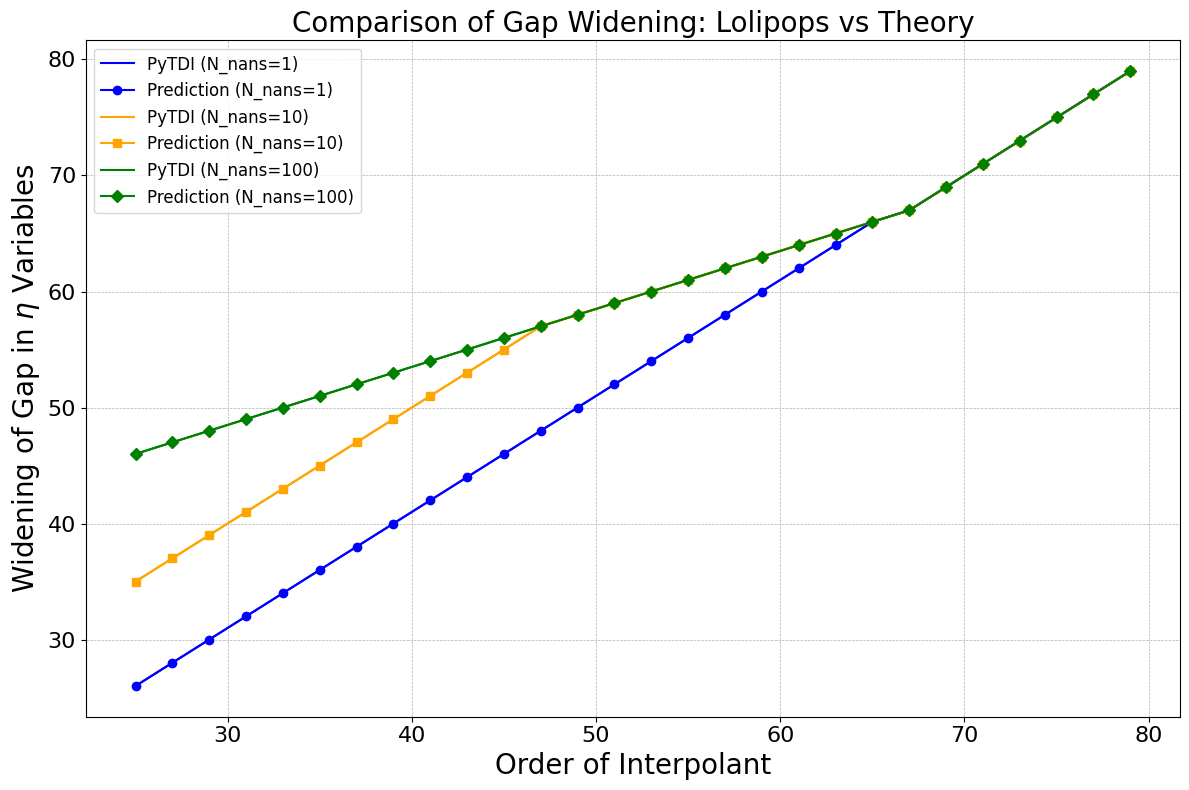

In [443]:
import matplotlib.pyplot as plt
plt.clf()
# Create a single plot for all gap configurations
plt.figure(figsize=(12, 8))

# Define markers and colors for each gap configuration
markers = ["o", "s", "D"]
colors = ["blue", "orange", "green"]

# Loop through each gap configuration and plot the results
for idx, (N_nans, results) in enumerate(results_by_order.items()):
    # Extract data for this N_nans configuration
    orders = [result["order"] for result in results]
    widening_gap_eta_pytdi = [result["widening_gap_eta_pytdi"] for result in results]
    widening_gap_eta_theory = [result["widening_gap_eta_theory"] for result in results]

    # Plot pytdi results (solid lines)
    plt.plot(
        orders, widening_gap_eta_pytdi,
        label=f"PyTDI (N_nans={N_nans})", 
        linestyle="-", color=colors[idx], zorder=1
    )
    
    # Plot theoretical results (dashed lines)
    plt.plot(
        orders, widening_gap_eta_theory, 
        label=f"Prediction (N_nans={N_nans})", 
        marker=markers[idx], color=colors[idx], zorder=2
    )

# Add labels, legend, and grid
plt.xlabel("Order of Interpolant", fontsize=20)
plt.ylabel(r"Widening of Gap in $\eta$ Variables", fontsize=20)
plt.title("Comparison of Gap Widening: Lolipops vs Theory", fontsize=20)
plt.legend(fontsize=12, loc="upper left")
plt.grid(True, linestyle="--", linewidth=0.5)

# Increase tick sizes
plt.tick_params(axis="both", which="major", labelsize=16)

# Save and show the plot
plt.tight_layout()
# plt.savefig("../Plots/gap_widening_comparison_all_configs.png", dpi=300)  # Save as a high-resolution image
plt.show()

# Now let's try to do the same thing but with factorized variables

We have no shown that the widening of the gap in the $\eta$ variables is sensitive to three things:

* The number of consecutive missing data in the telemetry variables
* The integer delay used when computing the interpolation
* The order of the interpolant. 

However, the quantity that L2A and L2D are most interested in are the L1 data products. In other words, the laser-cleaned TDI combinations $X$, $Y$ and $Z$ for various generations of TDI. Below we will do a similar analysis but now considering the TDI variables. 



In [460]:
from tqdm import tqdm as tqdm
order = 45
results_TDI_testing_N_nans = []

N_nans_in_telem_values = np.logspace(0, 2, num=50, dtype=int)  # Logarithmic spacing from 1 to 10000

for N_nans in tqdm(N_nans_in_telem_values):
    # Construct masking function
    masking_function = construct_mask_single_gap(N_nans, length=simlen)
        
    # Generate telemetry with gaps
    data_w_gaps = nanify_telemetry_variables(
        data, masking_function
    )
        
    # Compute eta variables with gaps
    etas_w_gaps_nans = compute_etas(
        data_w_gaps, order = 45, unit = "frequency"
    )
    TDI_X = []
    for gen in range(1,3):
        # rot = 0 stands for TDI X variable 
        result = compute_factorized_michelson(
            data_w_gaps, etas = etas_w_gaps_nans, rot = 0, order = order, generation = gen
    )
        TDI_X.append(result)
        
    # Calculate N_nans and widening for lolipops
    N_nans_in_TDI = [np.sum(np.isnan(TDI_X[i])) for i in range(len(TDI_X))]
    N_nans_in_X1_pytdi = N_nans_in_TDI[0] 
    N_nans_in_X2_pytdi = N_nans_in_TDI[1] 

    widening_gap_X1_pytdi = N_nans_in_X1_pytdi - N_nans
    widening_gap_X2_pytdi = N_nans_in_X2_pytdi - N_nans
        
    # Calculate N_nans and widening for theoretical model
    _, N_nans_in_X1_theory = widening_gap_X1(order, N_nans, delay)
    _, N_nans_in_X2_theory = widening_gap_X2(order, N_nans, delay)

    widening_gap_X1_theory = N_nans_in_X1_theory - N_nans
    widening_gap_X2_theory = N_nans_in_X2_theory - N_nans
        
    # Append results to the list
    results_TDI_testing_N_nans.append({
        "N_nans": N_nans,
        "N_nans_in_X1_pytdi": N_nans_in_X1_pytdi,
        "N_nans_in_X2_pytdi": N_nans_in_X2_pytdi,
        "widening_gap_X1_pytdi": widening_gap_X1_pytdi,
        "widening_gap_X2_pytdi": widening_gap_X2_pytdi,
        "N_nans_in_X1_theory": N_nans_in_X1_theory,
        "N_nans_in_X2_theory": N_nans_in_X2_theory,
        "widening_gap_X1_theory": widening_gap_X1_theory,
        "widening_gap_X2_theory": widening_gap_X2_theory
    })
    

  0%|          | 0/50 [00:00<?, ?it/s]2025-08-15 14:19:40,217 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x12255e6f0>'
2025-08-15 14:19:40,218 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x12255e6f0>'
2025-08-15 14:19:40,274 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x122579bb0>'
2025-08-15 14:19:40,275 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x122579bb0>'
2025-08-15 14:19:40,301 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x1223b44d0>'
2025-08-15 14:19:40,302 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x1223b44d0>'
2025-08-15 14:19:40,329 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x122579b80>'
2025-08-15 14:19:40,330 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x122579b80>'
2025-08-15 14:19:40,349 - INFO - Building combination '<pytdi.core.LISATDICombinat

# Plot the result

What we will show here is that the gap widening in the TDI variables is weakly dependent on the duration of the gap. We have a similar plot for the eta variables above. 

2025-08-15 14:46:14,515 - INFO - Substituting symbol O from STIXNonUnicode
2025-08-15 14:46:14,586 - INFO - Substituting symbol O from STIXNonUnicode
2025-08-15 14:46:14,618 - INFO - Substituting symbol O from STIXNonUnicode
2025-08-15 14:46:14,662 - INFO - Substituting symbol O from STIXNonUnicode
2025-08-15 14:46:15,299 - INFO - Substituting symbol O from STIXNonUnicode
2025-08-15 14:46:15,356 - INFO - Substituting symbol O from STIXNonUnicode
2025-08-15 14:46:15,494 - INFO - Substituting symbol O from STIXNonUnicode
2025-08-15 14:46:15,552 - INFO - Substituting symbol O from STIXNonUnicode


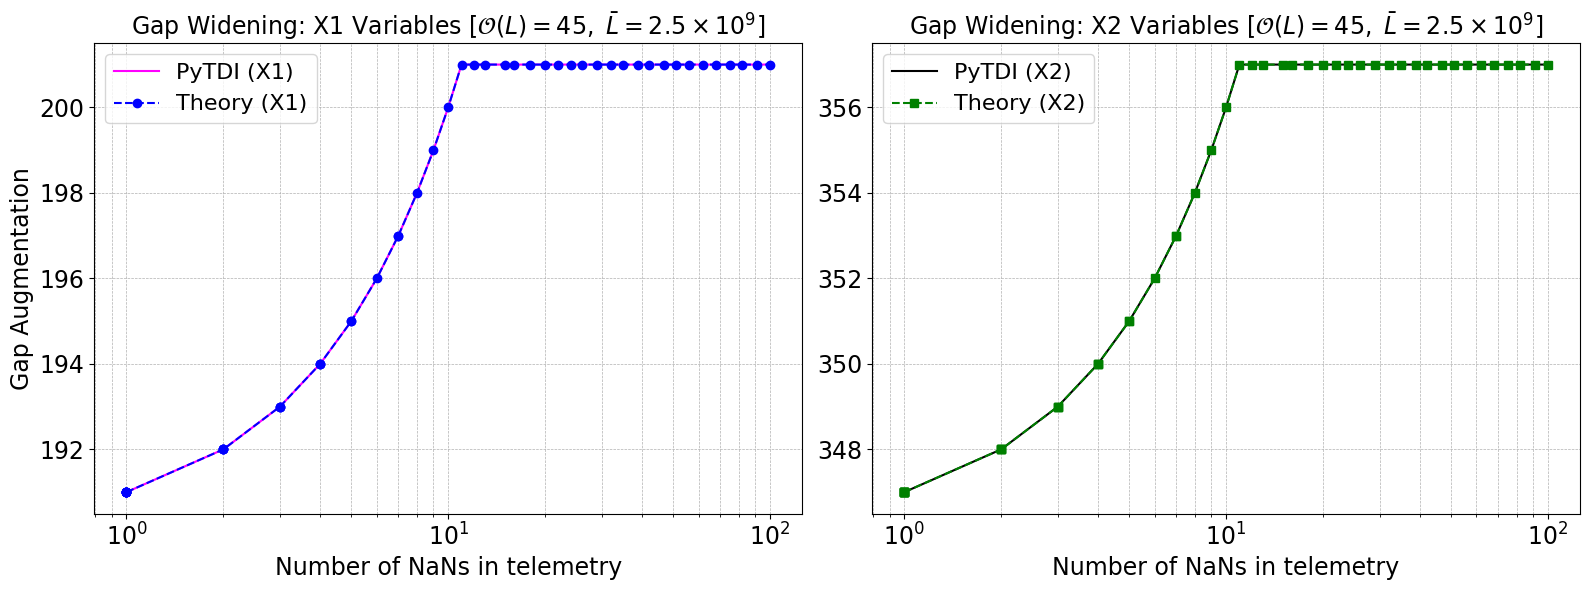

In [470]:
import matplotlib.pyplot as plt

# Extract data from results
N_nans_values = [result["N_nans"] for result in results_TDI_testing_N_nans]
widening_gap_X1_pytdi = [result["widening_gap_X1_pytdi"] for result in results_TDI_testing_N_nans]
widening_gap_X2_pytdi = [result["widening_gap_X2_pytdi"] for result in results_TDI_testing_N_nans]
widening_gap_X1_theory = [result["widening_gap_X1_theory"] for result in results_TDI_testing_N_nans]
widening_gap_X2_theory = [result["widening_gap_X2_theory"] for result in results_TDI_testing_N_nans]

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot X1 results on the left subplot
ax1.plot(
    N_nans_values, widening_gap_X1_pytdi, 
    label="PyTDI (X1)", linestyle="-", color="magenta"
)
ax1.plot(
    N_nans_values, widening_gap_X1_theory, 
    label="Theory (X1)", linestyle="--", marker="o", color="blue"
)
ax1.set_xscale("log")
ax1.set_xlabel("Number of NaNs in telemetry", fontsize=17)
ax1.set_ylabel("Gap Augmentation", fontsize=17)
ax1.set_title(
    r"Gap Widening: X1 Variables [$\mathcal{O}(L) = 45, \ \bar{L} = 2.5\times 10^{9}$]",
    fontsize=17
)
ax1.legend(fontsize=16, loc="upper left")
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)
ax1.tick_params(axis="both", which="major", labelsize=17)

# Plot X2 results on the right subplot
ax2.plot(
    N_nans_values, widening_gap_X2_pytdi, 
    label="PyTDI (X2)", linestyle="-", color="black"
)
ax2.plot(
    N_nans_values, widening_gap_X2_theory, 
    label="Theory (X2)", linestyle="--", marker="s", color="green"
)
ax2.set_xscale("log")
ax2.set_xlabel("Number of NaNs in telemetry", fontsize=17)
# ax2.set_ylabel("Widening of Gap in X2 Variables", fontsize=14)
ax2.set_title(
    r"Gap Widening: X2 Variables [$\mathcal{O}(L) = 45, \ \bar{L} = 2.5\times 10^{9}$]",
    fontsize=17
)
ax2.legend(fontsize=16, loc="upper left")
ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
ax2.tick_params(axis="both", which="major", labelsize=17)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig("/Users/murmar/Documents/workspace/gaps_tdi_work/gaps_tdi/gap_widening_comparison_TDI_subplots_higher_armlength.png", dpi=300)  # Save as a high-resolution image
plt.show()

2025-08-15 15:00:06,099 - INFO - Substituting symbol O from STIXNonUnicode
2025-08-15 15:00:06,165 - INFO - Substituting symbol O from STIXNonUnicode
2025-08-15 15:00:06,195 - INFO - Substituting symbol O from STIXNonUnicode
2025-08-15 15:00:06,236 - INFO - Substituting symbol O from STIXNonUnicode
2025-08-15 15:00:06,867 - INFO - Substituting symbol O from STIXNonUnicode
2025-08-15 15:00:07,127 - INFO - Substituting symbol O from STIXNonUnicode
2025-08-15 15:00:07,261 - INFO - Substituting symbol O from STIXNonUnicode
2025-08-15 15:00:07,312 - INFO - Substituting symbol O from STIXNonUnicode


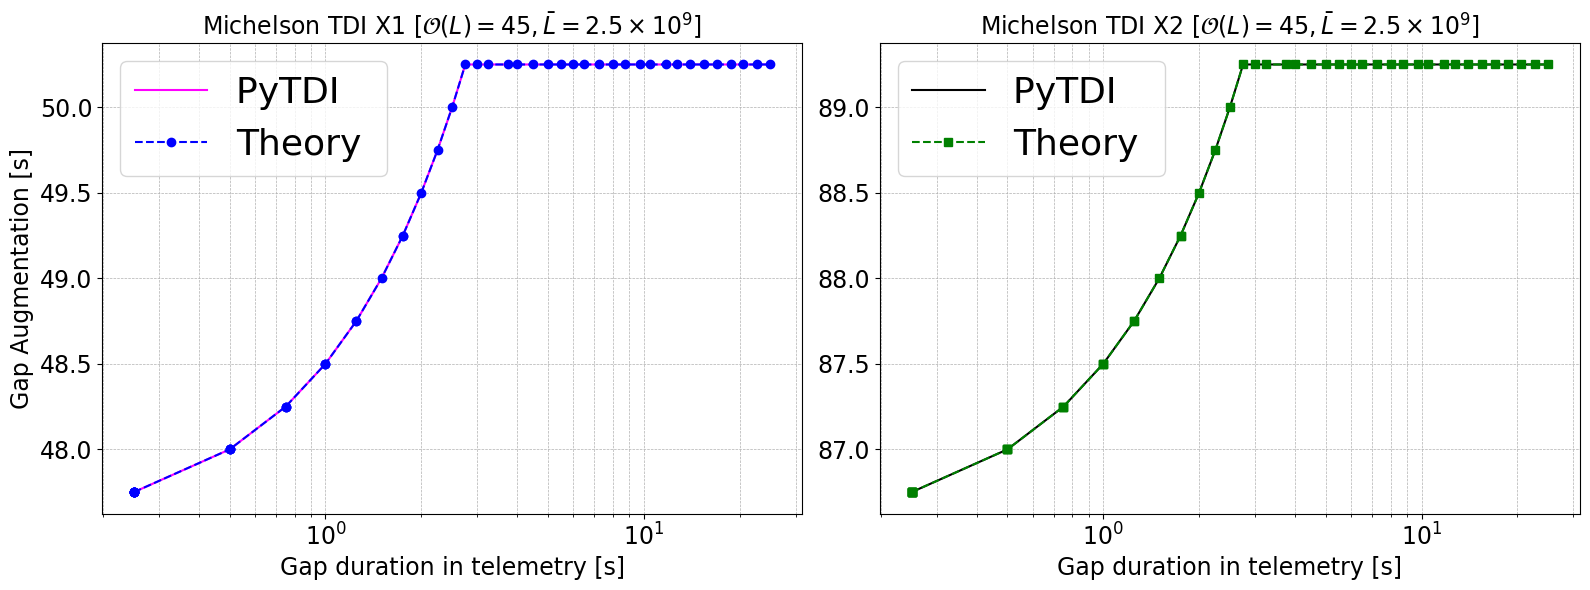

In [475]:
# Plot the results in seconds
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# Extract data from results
N_nans_values = [dt*result["N_nans"] for result in results_TDI_testing_N_nans]
widening_gap_X1_pytdi = [dt*result["widening_gap_X1_pytdi"] for result in results_TDI_testing_N_nans]
widening_gap_X2_pytdi = [dt*result["widening_gap_X2_pytdi"] for result in results_TDI_testing_N_nans]
widening_gap_X1_theory = [dt*(result["widening_gap_X1_theory"]) for result in results_TDI_testing_N_nans]
widening_gap_X2_theory = [dt*(result["widening_gap_X2_theory"]) for result in results_TDI_testing_N_nans]

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot X1 results on the left subplot
ax1.plot(
    N_nans_values, widening_gap_X1_pytdi, 
    label="PyTDI ", linestyle="-", color="magenta"
)
ax1.plot(
    N_nans_values, widening_gap_X1_theory, 
    label="Theory ", linestyle="--", marker="o", color="blue"
)
ax1.set_xscale("log")
ax1.set_xlabel("Gap duration in telemetry [s]", fontsize=17)
ax1.set_ylabel("Gap Augmentation [s]", fontsize=17)
ax1.set_title(r"Michelson TDI X1 [$\mathcal{O}(L) = 45, \bar{L} = 2.5\times 10^{9}$]", fontsize=17)
ax1.legend(fontsize=26, loc="upper left")
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)
ax1.tick_params(axis="both", which="major", labelsize=17)

# Plot X2 results on the right subplot
ax2.plot(
    N_nans_values, widening_gap_X2_pytdi, 
    label="PyTDI ", linestyle="-", color="black"
)
ax2.plot(
    N_nans_values, widening_gap_X2_theory, 
    label="Theory ", linestyle="--", marker="s", color="green"
)
ax2.set_xscale("log")
ax2.set_xlabel("Gap duration in telemetry [s]", fontsize=17)
# ax2.set_ylabel("Widening of Gap in X2 Variables", fontsize=14)
ax2.set_title(r"Michelson TDI X2 [$\mathcal{O}(L) = 45, \bar{L} = 2.5\times 10^{9}$]", fontsize=17)
ax2.legend(fontsize=26, loc="upper left")
ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
ax2.tick_params(axis="both", which="major", labelsize=17)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig("/Users/murmar/Documents/workspace/gaps_tdi_work/gaps_tdi/gap_widening_comparison_TDI_subplots_seconds_higher_armlength.png", dpi=300)  # Save as a high-resolution image
plt.show()

In [295]:
TDI_results_by_order = {}

# Define the gap configurations and range of orders
gap_configurations = [1, 10, 25]
orders = range(25, 81, 2)  # From 25 to 81 inclusive

# Loop over each gap configuration
for N_nans in gap_configurations:
    TDI_results_by_order[N_nans] = []  # Initialize results for this gap configuration
    # Construct masking function
    masking_function = construct_mask_single_gap(N_nans, length=simlen)
    
    for order in tqdm(orders):
        
        # Generate telemetry with gaps
        data_w_gaps = nanify_telemetry_variables(
            data, masking_function
        )
        
        # Compute eta variables with gaps
        etas_w_gaps_nans = compute_etas(
            data_w_gaps, order, unit="frequency"
        )        
        # Compute TDI variables for two generations
        TDI_X = []
        for gen in range(1, 3):
            result = compute_factorized_michelson(
                data_w_gaps, etas=etas_w_gaps_nans, rot=0, order=order, generation=gen
            )
            TDI_X.append(result)
        
        # Calculate N_nans and widening for pytdi
        N_nans_in_TDI = [np.sum(np.isnan(TDI_X[i])) for i in range(len(TDI_X))]
        widening_gap_X1_pytdi = N_nans_in_TDI[0] - N_nans
        widening_gap_X2_pytdi = N_nans_in_TDI[1] - N_nans

        # Calculate N_nans and widening for theoretical model
        _, N_nans_in_X1_theory = widening_gap_X1(order, N_nans, delay)
        _, N_nans_in_X2_theory = widening_gap_X2(order, N_nans, delay)
        widening_gap_X1_theory = N_nans_in_X1_theory - N_nans
        widening_gap_X2_theory = N_nans_in_X2_theory - N_nans
        
        # Append results to the list for this gap configuration
        TDI_results_by_order[N_nans].append({
            "order": order,
            "widening_gap_X1_pytdi": widening_gap_X1_pytdi,
            "widening_gap_X2_pytdi": widening_gap_X2_pytdi,
            "widening_gap_X1_theory": widening_gap_X1_theory,
            "widening_gap_X2_theory": widening_gap_X2_theory,
        })

  0%|          | 0/28 [00:00<?, ?it/s]2025-08-11 14:18:14,728 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x12255e6f0>'
2025-08-11 14:18:14,729 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x12255e6f0>'
2025-08-11 14:18:14,741 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x122579bb0>'
2025-08-11 14:18:14,742 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x122579bb0>'
2025-08-11 14:18:14,754 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x1223b44d0>'
2025-08-11 14:18:14,754 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x1223b44d0>'
2025-08-11 14:18:14,766 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x122579b80>'
2025-08-11 14:18:14,767 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x122579b80>'
2025-08-11 14:18:14,775 - INFO - Building combination '<pytdi.core.LISATDICombinat

<Figure size 640x480 with 0 Axes>

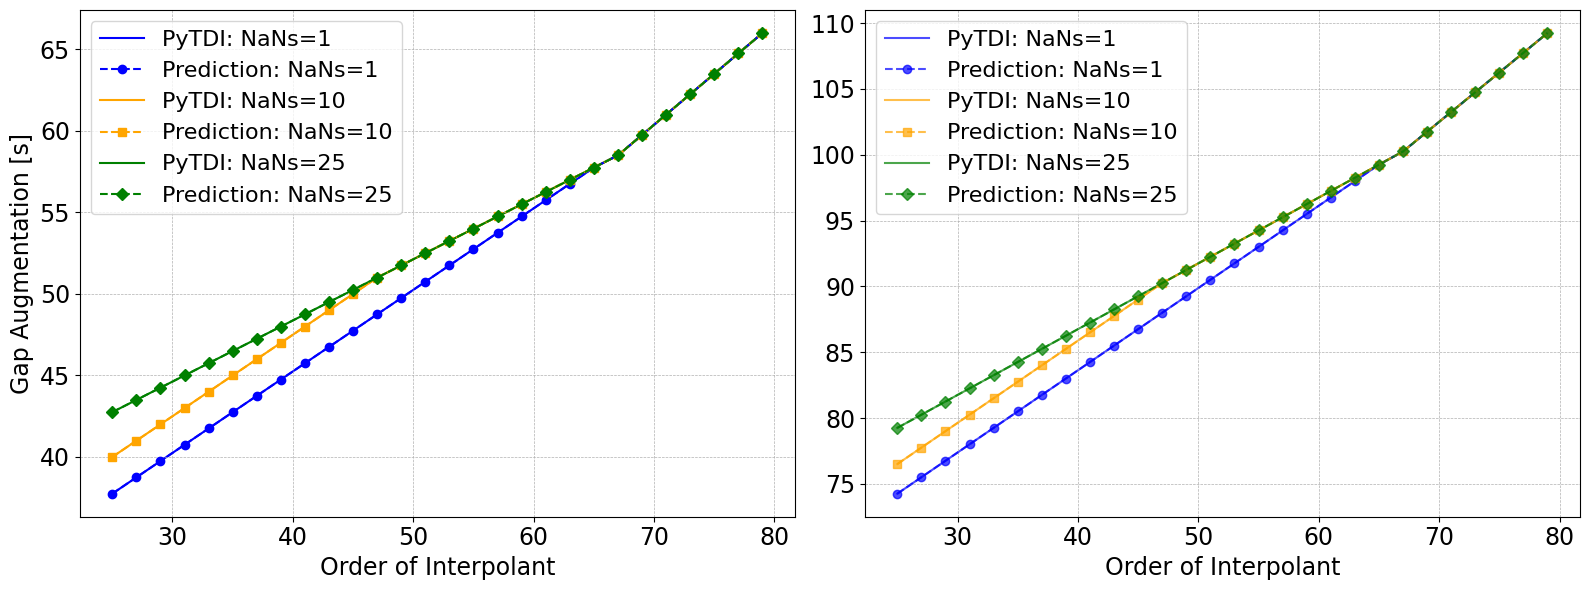

In [472]:
import matplotlib.pyplot as plt
plt.clf()

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Define markers and colors for each gap configuration
markers = ["o", "s", "D"]
colors = ["blue", "orange", "green"]

# Loop through each gap configuration and plot the results for X1
for idx, (N_nans, results) in enumerate(TDI_results_by_order.items()):
    # Extract data for this N_nans configuration
    orders = [result["order"] for result in results]
    widening_gap_X1_pytdi = [dt*result["widening_gap_X1_pytdi"] for result in results]
    widening_gap_X1_theory = [dt*(result["widening_gap_X1_theory"]) for result in results]

    # Plot X1 results on the left subplot
    ax1.plot(
        orders, widening_gap_X1_pytdi, 
        label=f"PyTDI: NaNs={N_nans}", 
        linestyle="-", color=colors[idx], zorder=1
    )
    ax1.plot(
        orders, widening_gap_X1_theory, 
        label=f"Prediction: NaNs={N_nans}", 
        marker=markers[idx], linestyle="--", color=colors[idx], zorder=2
    )

# Customize the left subplot (X1)
ax1.set_xlabel("Order of Interpolant", fontsize=17)
ax1.set_ylabel(r"Gap Augmentation [s]", fontsize=17)
# ax1.set_title(r"Gap Widening: $X_1$ Variables", fontsize=20)
ax1.legend(fontsize=16, loc="upper left")
ax1.grid(True, linestyle="--", linewidth=0.5)
ax1.tick_params(axis="both", which="major", labelsize=17)

# Loop through each gap configuration and plot the results for X2
for idx, (N_nans, results) in enumerate(TDI_results_by_order.items()):
    # Extract data for this N_nans configuration
    orders = [result["order"] for result in results]
    widening_gap_X2_pytdi = [dt*result["widening_gap_X2_pytdi"] for result in results]
    widening_gap_X2_theory = [dt*(result["widening_gap_X2_theory"]+1) for result in results]

    # Plot X2 results on the right subplot
    ax2.plot(
        orders, widening_gap_X2_pytdi, 
        label=f"PyTDI: NaNs={N_nans}", 
        linestyle="-", color=colors[idx], zorder=1, alpha=0.7
    )
    ax2.plot(
        orders, widening_gap_X2_theory, 
        label=f"Prediction: NaNs={N_nans}", 
        marker=markers[idx], linestyle="--", color=colors[idx], zorder=2, alpha=0.7
    )

# Customize the right subplot (X2)
ax2.set_xlabel("Order of Interpolant", fontsize=17)
# ax2.set_title(r"Gap Widening: $X_2$ Variables", fontsize=20)
ax2.legend(fontsize=16, loc="upper left")
ax2.grid(True, linestyle="--", linewidth=0.5)
ax2.tick_params(axis="both", which="major", labelsize=17)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig("/Users/murmar/Documents/workspace/gaps_tdi_work/gaps_tdi/gap_widening_comparison_TDI_subplots_change_gap_duration_seconds.png", dpi=300)  # Save as a high-resolution image
plt.show()

# The formulas check out

The formulas work extremely well for standard orders of interpolants $\mathcal{O}(L) \gtrsim 25$ providing that the missing data is contiguous. In other words, the \texttt{nans} are next to eachother. The formula *will* break down if you have multiple gaps that are very close to eachother. This is because as the nans propagate through the pipeline, the gated segments will start eating onto eachother. This means that the formula, predicting the total number of lost data will always over-estimate the loss, rather than underestimate it. This is good, we are being conservative. 

## The future goals

We will have multiple gaps of various durations. The question is how accurately (and quickly) can I predict the overall gap augmentation due to the TDI pipeline? Now I will use a generic masking function to do this. 

In [40]:
# Import the necessary functions from the multi_gap_utils module
# Assuming the functions are defined in a file named multi_gap_utils.py in the same directory
sys.path.append("..")  # if multi_gap_utils.py is in the parent directory
from utility_funcs.multi_gap_utils import (
    mask_eta, 
    mask_TDI_X,
    approx_total_nans_from_nan_blocks_eta,
    approx_total_nans_from_nan_blocks_X
)



In [27]:
# Consider now a longer simulation 

simlen_multi_gap = 1_050_000

instr_3_days_static = Instrument(size=simlen_multi_gap, dt = 0.25, orbits = 'static_orbits.h5', seed=1234)

instr_3_days_static.disable_all_noises(excluding=['laser', 'test-mass', 'oms']) 
instr_3_days_static.simulate()

instr_3_days_static.write('static_3_day_simulation.h5', mode='w')

2025-07-16 11:41:06,589 - INFO - Initializing instrumental simulation


2025-07-16 11:41:06,607 - INFO - Computing measurement time vector (size=1050000, dt=0.25)
2025-07-16 11:41:06,609 - INFO - Computing physics time vector (size=4200000, dt=0.0625)
2025-07-16 11:41:06,616 - INFO - Computing telemetry time vector (size=5, dt=86400.0)
2025-07-16 11:41:06,630 - INFO - Using orbit file 'static_orbits.h5'
2025-07-16 11:41:09,227 - INFO - Using pre-defined locking configuration 'N1-12'
2025-07-16 11:41:09,227 - WARNING - Using default set of locking beatnote frequencies; this might cause interferometric beatnote frequencies to fall outside the requirement range of 5..25 MHz
2025-07-16 11:41:09,227 - INFO - Designing antialiasing filter ('kaiser', 240, 1.1, 2.9)
2025-07-16 11:41:09,228 - INFO - Starting simulation
2025-07-16 11:41:09,228 - INFO - Generating clock noise
2025-07-16 11:41:09,302 - INFO - Generating modulation noise
2025-07-16 11:41:09,302 - INFO - Generating backlink noise
2025-07-16 11:41:09,303 - INFO - Generating test-mass acceleration noise
2

In [28]:
data_3_day_sim = Data.from_instrument(instr_3_days_static)

2025-07-16 11:42:30,043 - INFO - Loading instrument object '<lisainstrument.instrument.Instrument object at 0x14a7bd910>'
2025-07-16 11:42:30,044 - WARNING - You are using LISA Instrument in a version that might not be fully supported
2025-07-16 11:42:30,045 - INFO - Initializing data object
2025-07-16 11:42:30,045 - INFO - Computing delay derivatives


# Define the overall masking function

The masking function will take in a dictionary of gating functions

In [100]:
# Generate the mask with sampling interval 0.25 seconds

# Define the gap function 

# Construct gap class

sim_t = np.arange(0, simlen_multi_gap * dt, dt)

gap_definitions = {
    "planned": {
        "Instrumental Maintainance": {"rate_per_year": 5 * 260, "duration_hr": 0.0001*3.3}
    },
    "unplanned": {
        "Instrument breaks": {"rate_per_year": 3, "duration_hr": 60},
    }
}

# Initialise class with rates, and sampling properties.
generator_gap_3_day = GapMaskGenerator(
    sim_t,
    dt,
    gap_definitions,
    treat_as_nan=True,
    planseed=11_07_1993,
    unplanseed=16_12_1997
)

# Generate the mask full of gaps
full_mask_3_day = generator_gap_3_day.generate_mask(include_unplanned=False, include_planned=True)
N_nans_check = np.sum(np.isnan(full_mask_3_day))

extract_summary = generator_gap_3_day.summary(mask = full_mask_3_day)
from pprint import pprint
pprint(extract_summary['mask_analysis'])

{'duty_cycle_percent': np.float64(99.9962),
 'number_of_gap_segments': 10,
 'total_gap_hours': np.float64(0.0),
 'total_gap_samples': 40}


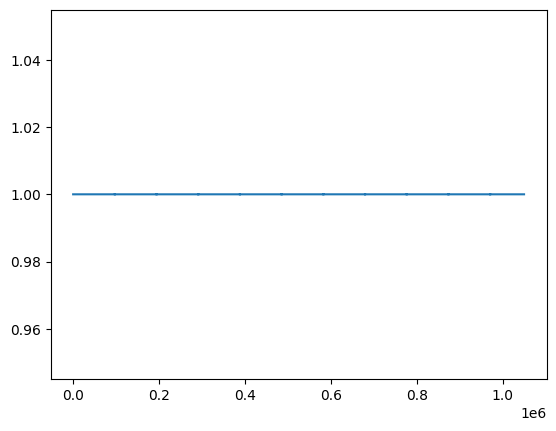

In [101]:
plt.plot(full_mask_3_day)

In [102]:
# Let's compute the true number of nans in the eta variables
N_nans_multiple_gaps = np.sum(np.isnan(full_mask_3_day))

data_w_multi_gaps = nanify_telemetry_variables(data_3_day_sim, full_mask_3_day)
etas_w_multi_gaps = compute_etas(
    data_w_multi_gaps, order=order, unit="frequency"
)

LTT = data_w_multi_gaps.delays['d_12'][1000:][0]  # Take the mean LTT
delay_integer_fraction = LTT / dt  # Here we take the mean LTT. "samples"
eta_mask = mask_eta(full_mask_3_day, delay=delay_integer_fraction, order=order)

print("")
print("Doing things using pytdi")
N_nans_in_eta_w_multi_gaps_pytdi = np.sum(np.isnan(etas_w_multi_gaps["eta_12"]))
widening_gap_eta_pytdi = N_nans_in_eta_w_multi_gaps_pytdi - N_nans_multiple_gaps
print("Number of nans in the eta variables = ", N_nans_in_eta_w_multi_gaps_pytdi)
print("Overall widening of gap in eta variables = ", widening_gap_eta_pytdi)
print("")
print("Now doing things carefully but using theory")

N_nans_in_eta_w_multi_gaps_theory = np.sum(np.isnan(eta_mask))
widening_gap_eta_theory = N_nans_in_eta_w_multi_gaps_theory - N_nans_multiple_gaps
print("Number of nans in the eta variables = ", N_nans_in_eta_w_multi_gaps_theory)
print("Overall widening of gap in eta variables = ", widening_gap_eta_theory)

# Can I try to approximate this result?
print("")
print("Now using our quick approximation formula")
approx_nans_in_eta = approx_total_nans_from_nan_blocks_eta(full_mask_3_day, delay, lagrange_order=order, delay_number=1.0)

approx_N_nans_in_eta_w_multi_gaps_theory = np.sum(np.isnan(eta_mask))
approx_widening_gap_eta_theory = approx_N_nans_in_eta_w_multi_gaps_theory - N_nans_multiple_gaps
print("Approx number of nans in the eta variables = ", approx_N_nans_in_eta_w_multi_gaps_theory)
print("Overall widening of gap in eta variables = ", approx_widening_gap_eta_theory)



2025-07-16 14:19:06,124 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x14a424e60>'
2025-07-16 14:19:06,125 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x14a424e60>'
/opt/miniconda3/envs/pytdi_env/lib/python3.12/site-packages/pytdi/dsp.py:113: RuntimeWarning: invalid value encountered in cast
  shift_ints = shift_ints.astype(int)
2025-07-16 14:19:07,218 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x14a41a840>'
2025-07-16 14:19:07,220 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x14a41a840>'
2025-07-16 14:19:08,316 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x14a426840>'
2025-07-16 14:19:08,317 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x14a426840>'
2025-07-16 14:19:09,408 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x14a424920>'
2025-07-16 14:19:09,410 - INFO - Evaluate combination '<pytdi.co


Doing things using pytdi
Number of nans in the eta variables =  530
Overall widening of gap in eta variables =  490

Now doing things carefully but using theory
Number of nans in the eta variables =  530
Overall widening of gap in eta variables =  490

Now using our quick approximation formula
Approx number of nans in the eta variables =  530
Overall widening of gap in eta variables =  490


<!-- # Try to do the same thing but with TDI X variables for both generations -->

In [103]:

# Compute TDI variables for generation 1 and generation 2
order = 45
TDI_X = []
for gen in range(1, 3):
    result = compute_factorized_michelson(
    data_w_multi_gaps, etas = etas_w_multi_gaps, rot=0, order=order, generation=gen
    )
    TDI_X.append(result)


2025-07-16 14:19:16,810 - INFO - Initializing combination with components '{'eta_12': [(1, [])], 'eta_21': [(1, ['D_12'])]}'
2025-07-16 14:19:16,811 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x15a3868a0>'
2025-07-16 14:19:16,813 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x15a3868a0>'


2025-07-16 14:19:17,204 - INFO - Initializing combination with components '{'eta_13': [(1, [])], 'eta_31': [(1, ['D_13'])]}'
2025-07-16 14:19:17,204 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x159814b90>'
2025-07-16 14:19:17,206 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x159814b90>'
2025-07-16 14:19:17,574 - INFO - Initializing combination with components '{'x_arm_1': [(-1, []), (1, ['D_13', 'D_31'])], 'x_arm_2': [(1, []), (-1, ['D_12', 'D_21'])]}'
2025-07-16 14:19:17,575 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x14fb6b800>'
2025-07-16 14:19:17,721 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x14fb6b800>'
2025-07-16 14:19:18,473 - INFO - Initializing combination with components '{'eta_12': [(1, [])], 'eta_21': [(1, ['D_12'])]}'
2025-07-16 14:19:18,474 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x14a7d8bf0>'
2025-07-16 14:19:18,475 - INFO 

In [114]:
N_nans_multiple_gaps = np.sum(np.isnan(full_mask_3_day))

X2_mask = mask_TDI_X(full_mask_3_day, delay_integer_fraction, order=order, generation=2)

check_N_nans_in_X2_theory = approx_total_nans_from_nan_blocks_X(full_mask_3_day, delay_integer_fraction, order=order, generation=2)

N_nans_using_X2_mask = np.sum(np.isnan(X2_mask))

N_nans_using_pytdi_X2 = np.sum(np.isnan(TDI_X[1]))

print("widening for TDI2 using pytdi ", N_nans_using_pytdi_X2 - N_nans_multiple_gaps)
print("widening for TDI2 using mask ", N_nans_using_X2_mask - N_nans_multiple_gaps)
print("widening for TDI2 using formulas ", check_N_nans_in_X2_theory - N_nans_multiple_gaps)

widening for TDI2 using pytdi  3500
widening for TDI2 using mask  3500
widening for TDI2 using formulas  3500


In [115]:

print("Using pytdi")
N_nans_in_X1_w_multi_gaps_pytdi = np.sum(np.isnan(TDI_X[0]))
N_nans_in_X2_w_multi_gaps_pytdi = np.sum(np.isnan(TDI_X[1]))

widening_gap_X1_pytdi = N_nans_in_X1_w_multi_gaps_pytdi - N_nans_multiple_gaps
widening_gap_X2_pytdi = N_nans_in_X2_w_multi_gaps_pytdi - N_nans_multiple_gaps
print("pytdi: Number of nans in X1 variables = ", N_nans_in_X1_w_multi_gaps_pytdi)
print("pytdi: Widening of gap in X1 variables = ", widening_gap_X1_pytdi)
print("pytdi: Number of nans in X2 variables = ", N_nans_in_X2_w_multi_gaps_pytdi)
print("pytdi: Widening of gap in X2 variables = ", widening_gap_X2_pytdi)

print("")
print("Now doing things carefully but using theory")
print("")

# Compute the masking function for X1 and X2 variables using formulas
X1_mask = mask_TDI_X(full_mask_3_day, delay, order=order, generation=1)
X2_mask = mask_TDI_X(full_mask_3_day, delay, order=order, generation=2)

N_nans_in_X1_w_multi_gaps_theory = np.sum(np.isnan(X1_mask))
N_nans_in_X2_w_multi_gaps_theory = np.sum(np.isnan(X2_mask))
widening_gap_X1_theory = N_nans_in_X1_w_multi_gaps_theory - N_nans_multiple_gaps
widening_gap_X2_theory = N_nans_in_X2_w_multi_gaps_theory - N_nans_multiple_gaps
print("Theory: Number of nans in X1 variables = ", N_nans_in_X1_w_multi_gaps_theory)
print("Theory: Widening of gap in X1 variables = ", widening_gap_X1_theory)
print("Theory: Number of nans in X2 variables = ", N_nans_in_X2_w_multi_gaps_theory)
print("Theory: Widening of gap in X2 variables = ", widening_gap_X2_theory)
print("")
# Can I try to approximate this result?
print("Now using our quick approximation formula")
print("")
approx_nans_in_X1 = approx_total_nans_from_nan_blocks_X(full_mask_3_day, delay_integer_fraction, order=order, generation=1)
approx_nans_in_X2 = approx_total_nans_from_nan_blocks_X(full_mask_3_day, delay_integer_fraction, order=order, generation=2)

approx_N_nans_in_X1_w_multi_gaps_theory = np.sum(np.isnan(X1_mask))
approx_N_nans_in_X2_w_multi_gaps_theory = np.sum(np.isnan(X2_mask))
approx_widening_gap_X1_theory = approx_N_nans_in_X1_w_multi_gaps_theory - N_nans_multiple_gaps
approx_widening_gap_X2_theory = approx_N_nans_in_X2_w_multi_gaps_theory - N_nans_multiple_gaps
print("Approx: Number of nans in X1 variables = ", approx_N_nans_in_X1_w_multi_gaps_theory)
print("Approx:  Widening of gap in X1 variables = ", approx_widening_gap_X1_theory)
print("Approx: Number of nans in X2 variables = ", approx_N_nans_in_X2_w_multi_gaps_theory)
print("Approx:  Widening of gap in X2 variables = ", approx_widening_gap_X2_theory)

Using pytdi
pytdi: Number of nans in X1 variables =  1980
pytdi: Widening of gap in X1 variables =  1940
pytdi: Number of nans in X2 variables =  3540
pytdi: Widening of gap in X2 variables =  3500

Now doing things carefully but using theory

Theory: Number of nans in X1 variables =  1980
Theory: Widening of gap in X1 variables =  1940
Theory: Number of nans in X2 variables =  3540
Theory: Widening of gap in X2 variables =  3500

Now using our quick approximation formula

Approx: Number of nans in X1 variables =  1980
Approx:  Widening of gap in X1 variables =  1940
Approx: Number of nans in X2 variables =  3540
Approx:  Widening of gap in X2 variables =  3500
